In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
import os
from pathlib import Path

scripts_dir = Path().resolve()
parent_dir = scripts_dir.parent
sys.path.insert(0, str(parent_dir))
import Functions.HMM as HMM
import Functions.kinematics as kinematics
import Functions.patch as patch
from SSM.ssm.plots import gradient_cmap

color_names = ['black', "blue", "red", "tan", "green", "brown", "purple", "orange", 'turquoise', "yellow", 'pink', 'darkblue']
aeon_dir = scripts_dir.parent.parent/'aeon_mecha'/'aeon'
sys.path.insert(0, str(aeon_dir))
import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02, exp01
from aeon.analysis.utils import visits, distancetravelled
from aeon.schema.schemas import social02, social01

In [12]:
root = '/ceph/aeon/aeon/data/raw/AEON3/social0.2'
#mouse_pos = pd.read_parquet('../SocialData/HMMData/' + 'Pre' + "_" + 'BAA-1104047' + '.parquet', engine='pyarrow')
patch = 'Patch2'
start = pd.Timestamp('2024-02-03 07:59:59.980000') + pd.Timedelta('0.01S')
end = start + pd.Timedelta('0.01S')
#end = mouse_pos.index[-1]
if patch == 'Patch1': encoder = aeon.load(root, social02.Patch1.Encoder, start=start, end=end)
elif patch == 'Patch2': encoder = aeon.load(root, social02.Patch2.Encoder, start=start, end=end)
else: encoder = aeon.load(root, social02.Patch3.Encoder, start=start, end=end)

encoder = encoder[::5]

'''w = -distancetravelled(encoder.angle).to_numpy()
dw = np.concatenate((np.array([0]), w[:-1]- w[1:]))

encoder['distance'] = pd.Series(w, index=encoder.index)
#encoder['Distance'] = pd.Series(w, index=encoder.index)
#encoder['Distance'] = encoder['distance'].rolling('10S').mean()

w = encoder['Distance'].to_numpy()
dw = np.concatenate((np.array([0]), w[:-1]- w[1:]))
encoder['DistanceChange'] = pd.Series(dw, index=encoder.index)
encoder['DistanceChange'] = encoder['DistanceChange'].rolling('10S').mean()
encoder['Move'] = np.where(abs(encoder.DistanceChange) > 0.001, 1, 0)'''

encoder

/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:149: UserWarning: data index for Patch2_90_* contains duplicate keys!
  warnings.warn(f"data index for {reader.pattern} contains duplicate keys!")


KeyError: Timestamp('2024-02-03 07:59:59.990000')

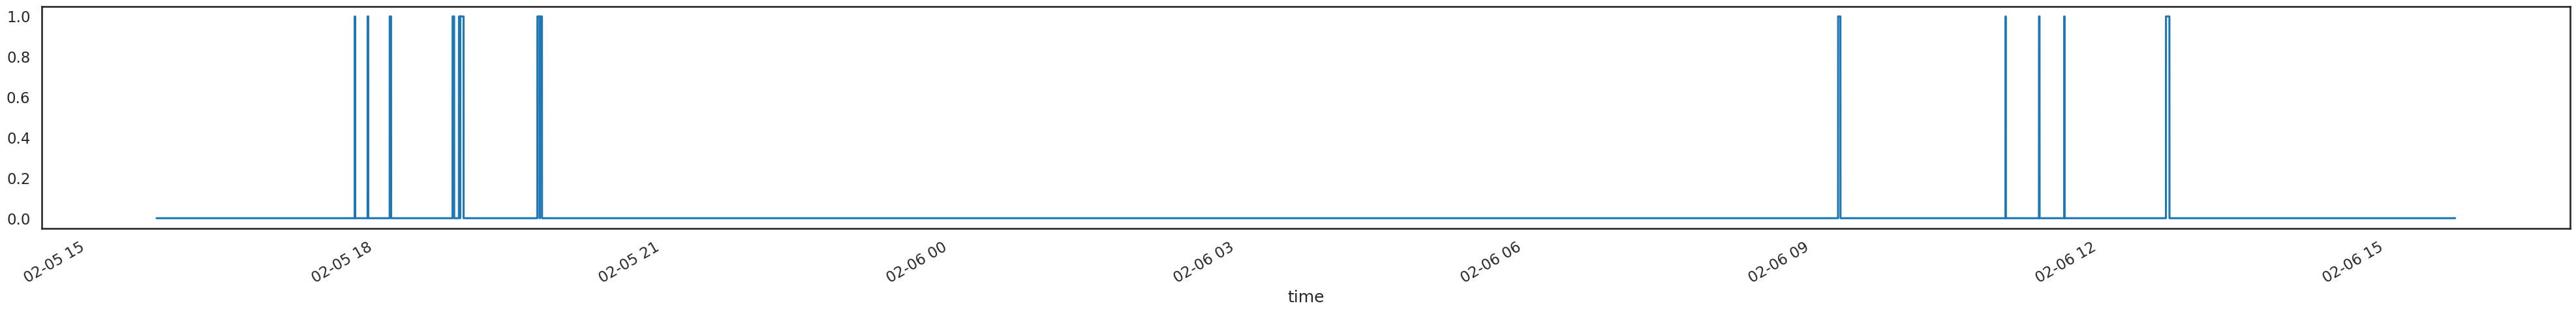

In [38]:
fid, axs = plt.subplots(1,1, figsize = (50,5))
encoder.Move.plot(ax = axs)
plt.show()

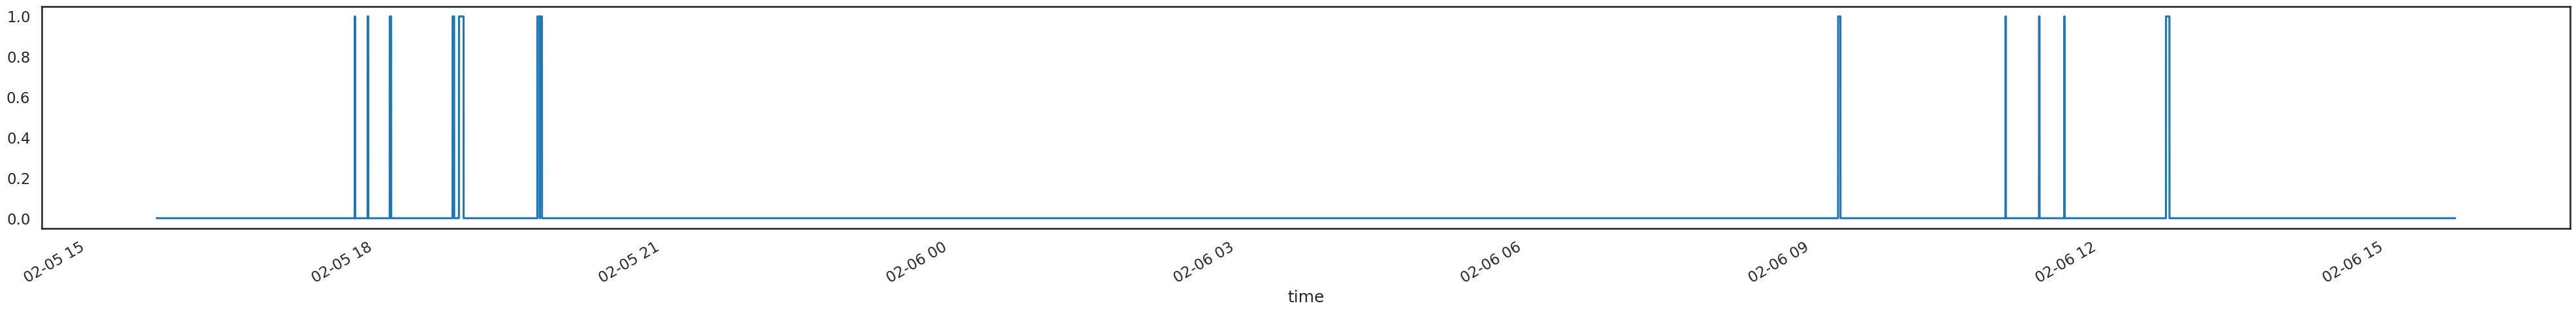

In [41]:
interval_seconds = 10

# Identify groups where Move changes
groups = encoder['Move'].ne(encoder['Move'].shift()).cumsum()

# Identify groups of Move = 1
one_groups = encoder[encoder['Move'] == 1].groupby(groups).groups

# Convert to list of indices
one_groups = list(one_groups.values())

# Loop through groups of Move = 1 and check intervals
for i in range(len(one_groups) - 1):
    end_current_group = one_groups[i][-1]
    start_next_group = one_groups[i + 1][0]
    duration = start_next_group - end_current_group

    # Check if interval is shorter than threshold
    if duration < pd.Timedelta(seconds=interval_seconds):
        # Fill the interval with Move = 1
        encoder.loc[end_current_group:start_next_group, 'Move'] = 1

fid, axs = plt.subplots(1,1, figsize = (50,5))
encoder.Move.plot(ax = axs)
plt.show()

In [25]:
social02.Patch1.DeliverPellet.value = 1
social02.Patch2.DeliverPellet.value = 1
social02.Patch3.DeliverPellet.value = 1
data = aeon.load(root, social02.Patch1.DeliverPellet, start=start, end=end)
display(data)

,event
time,
2024-02-05 15:44:00.567488194,TriggerPellet
2024-02-05 17:55:40.311488152,TriggerPellet
2024-02-05 18:09:39.118495941,TriggerPellet


In [34]:
LABELS = [
    ['Pre','BAA-1104045'],
    ['Pre','BAA-1104047'],
    ['Post','BAA-1104045'],
    ['Post','BAA-1104047']
]

for i in range(len(LABELS)):
    type, mouse = LABELS[i][0], LABELS[i][1]
    try:
        Visits_Patch1 = pd.read_parquet('../SocialData/VisitData/'  + type + "_" + mouse +'_Visit1.parquet', engine='pyarrow')
        display(Visits_Patch1)
    except FileNotFoundError:
        continue

,start,end,distance,duration,speed,acceleration,entry,patch,pellet
0,2024-01-31 11:28:50.981984138,2024-01-31 11:28:50.984000206,-0.006136,0.002016,51.466773,514.125286,-0.898016,Patch1,0
1,2024-01-31 14:25:26.248000145,2024-01-31 14:25:34.705984116,-1.394474,8.457983,17.208307,40.495753,209.468000,Patch1,0
2,2024-01-31 14:32:46.363999844,2024-01-31 14:40:00.221983910,-3188.345106,433.857984,24.340322,61.950235,649.583999,Patch1,18
3,2024-01-31 14:58:09.035999775,2024-01-31 15:00:35.237984180,-1269.466526,146.201984,31.224283,96.302934,32.155999,Patch1,6
4,2024-01-31 15:04:00.831999779,2024-01-31 15:05:00.073984146,-191.322091,59.241984,101.743853,225.974478,10.051999,Patch1,1
...,...,...,...,...,...,...,...,...,...
77,2024-02-03 12:38:30.067999840,2024-02-03 12:38:48.025983810,-72.357688,17.957983,65.354176,75.721865,5.967999,Patch1,1
78,2024-02-03 12:39:12.281983852,2024-02-03 12:45:39.053984165,-3051.562428,386.772000,1.362761,2.213081,48.181983,Patch1,8
79,2024-02-03 12:55:05.443999767,2024-02-03 12:55:17.993984222,-42.558293,12.549984,17.766207,29.372706,53.343999,Patch1,0
80,2024-02-03 12:56:23.872000217,2024-02-03 13:02:20.049983978,-2927.018596,356.177983,32.910685,47.284614,26.772000,Patch1,8


In [42]:
encoder = pd.read_parquet('encoder.parquet', engine='pyarrow')
encoder

,angle,intensity,Distance,DistanceChange,Move
time,,,,,
2024-01-31 11:28:50.980000019,15700,3228,-0.000000,0.000000,0
2024-01-31 11:28:50.989984035,15698,3219,0.003068,-0.001534,1
2024-01-31 11:28:51.000000000,15704,3223,-0.006136,0.002045,1
2024-01-31 11:28:51.009984016,15702,3222,-0.003068,0.000767,0
2024-01-31 11:28:51.019999981,15697,3224,0.004602,-0.000920,0
...,...,...,...,...,...
2024-02-02 11:28:50.932000160,16085,3188,175.338570,0.000003,0
2024-02-02 11:28:50.941984177,16082,3193,175.343172,0.000005,0
2024-02-02 11:28:50.952000141,16082,3187,175.343172,-0.000003,0


In [35]:
def find_obj(dotmap, obj):
    """Returns a list of objects of type `obj` found in a DotMap."""
    objs = []
    for value in dotmap.values():
        if isinstance(value, obj):
            objs.append(value)
        elif isinstance(value, DotMap):
            objs.extend(find_obj(value, obj))
    return objs
root = '/ceph/aeon/aeon/data/raw/AEON3/social0.1/'
readers = find_obj(social01, reader.Reader)
start_time = pd.Timestamp("2023-12-05 15:00:00")
end_time = pd.Timestamp("2023-12-07 11:00:00")
for r in readers:
    data = aeon.load(root, r, start=start_time, end=end_time)
    #assert not data.empty, f"No data found with {r}."
    print(f"\n{r.pattern}:")
    display(data.head())


Metadata:


,workflow,commit,metadata
time,,,



Environment_EnvironmentState_*:


,state
time,
2023-12-05 15:28:04.552000046,Maintenance
2023-12-05 15:30:23.199999809,Experiment



Environment_BlockState_*:


,pellet_ct,pellet_ct_thresh,due_time
time,,,
2023-12-05 15:02:21.032000065,33,39,0001-01-01T00:00:00.0000000
2023-12-05 15:02:45.599999905,34,39,0001-01-01T00:00:00.0000000
2023-12-05 15:02:56.763999939,35,39,0001-01-01T00:00:00.0000000
2023-12-05 15:09:38.004000186,36,39,0001-01-01T00:00:00.0000000
2023-12-05 15:09:59.627999783,37,39,0001-01-01T00:00:00.0000000



Environment_LightEvents_*:


,channel,value
time,,
2023-12-05 15:00:00,3,78
2023-12-05 15:00:00,7,78
2023-12-05 15:00:00,5,0
2023-12-05 15:00:00,18,0
2023-12-05 15:00:00,35,0



Environment_MessageLog_*:


,priority,type,message
time,,,
2023-12-05 15:03:02.760000229,Alert,TrackingFailure,CAA-1120747
2023-12-05 15:06:32.019999981,Alert,TrackingFailure,CAA-1120747
2023-12-05 15:11:06.400000095,Alert,TrackingFailure,CAA-1120747
2023-12-05 15:14:37.320000172,Alert,TrackingFailure,CAA-1120747
2023-12-05 15:19:46.980000019,Alert,TrackingFailure,CAA-1120747



Environment_SubjectState_*:


,id,weight,type
time,,,



Environment_SubjectVisits_*:


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:149: UserWarning: data index for Environment_SubjectVisits_* contains duplicate keys!
  warnings.warn(f"data index for {reader.pattern} contains duplicate keys!")


,id,type,region
time,,,
2023-12-05 15:02:09.440000057,CAA-1120747,Enter,Patch2
2023-12-05 15:02:09.519999981,CAA-1120747,Exit,Patch2
2023-12-05 15:02:14.900000095,CAA-1120747,Enter,Patch3
2023-12-05 15:02:15.000000000,CAA-1120747,Exit,Patch3
2023-12-05 15:02:15.380000114,CAA-1120747,Enter,Patch3



Environment_SubjectWeight_*:


,weight,confidence,subject_id,int_id
time,,,,
2023-12-05 15:06:48.539999962,29.0,1,CAA-1120747,1
2023-12-05 15:06:48.639999866,29.0,1,CAA-1120747,1
2023-12-05 15:06:48.699999809,29.0,1,CAA-1120747,1
2023-12-05 15:06:48.800000191,29.0,1,CAA-1120747,1
2023-12-05 15:06:48.900000095,29.0,1,CAA-1120747,1



CameraTop_*:


,hw_counter,hw_timestamp,_frame,_path,_epoch
time,,,,,
2023-12-05 15:00:00.000000000,43630109,1213616188907296,0,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.019999981,43630110,1213616208904456,1,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.039999962,43630111,1213616228906320,2,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.059999943,43630112,1213616248904136,3,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.079999924,43630113,1213616268905808,4,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23



CameraTop_test-node1*:


,class,class_likelihood,part,x,y,part_likelihood
time,,,,,,
2023-12-05 15:00:00.039999962,1.0,0.996751,centroid,722.840515,992.555054,0.959718
2023-12-05 15:00:00.039999962,1.0,0.999031,centroid,547.409607,1018.986206,0.959718
2023-12-05 15:00:00.099999905,1.0,0.996351,centroid,722.785522,992.550964,0.955844
2023-12-05 15:00:00.099999905,1.0,0.998975,centroid,547.415039,1018.981812,0.955844
2023-12-05 15:00:00.159999847,1.0,0.996403,centroid,722.839233,992.551270,0.958654



CameraNorth_*:


,hw_counter,hw_timestamp,_frame,_path,_epoch
time,,,,,
2023-12-05 15:00:00.000000000,43647045,1213614801677320,0,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.019999981,43647046,1213614821679320,1,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.039999962,43647047,1213614841677136,2,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.059999943,43647048,1213614861679320,3,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.079999924,43647049,1213614881677024,4,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23



CameraSouth_*:


,hw_counter,hw_timestamp,_frame,_path,_epoch
time,,,,,
2023-12-05 15:00:00.000000000,43647045,1213616594929320,0,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.019999981,43647046,1213616614926512,1,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.039999962,43647047,1213616634928184,2,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.059999943,43647048,1213616654926216,3,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.079999924,43647049,1213616674928320,4,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23



CameraEast_*:


,hw_counter,hw_timestamp,_frame,_path,_epoch
time,,,,,
2023-12-05 15:00:00.000000000,43647045,1213617659764752,0,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.019999981,43647046,1213617679766296,1,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.039999962,43647047,1213617699763808,2,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.059999943,43647048,1213617719766240,3,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.079999924,43647049,1213617739763568,4,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23



CameraWest_*:


,hw_counter,hw_timestamp,_frame,_path,_epoch
time,,,,,
2023-12-05 15:00:00.000000000,43647045,1213616683453320,0,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.019999981,43647046,1213616703450808,1,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.039999962,43647047,1213616723452296,2,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.059999943,43647048,1213616743450216,3,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.079999924,43647049,1213616763452000,4,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23



CameraPatch1_*:


,hw_counter,hw_timestamp,_frame,_path,_epoch
time,,,,,
2023-12-05 15:00:00.000000000,109117563,1213617387435808,0,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.007999897,109117564,1213617395434272,1,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.015999794,109117565,1213617403436432,2,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.024000168,109117566,1213617411435136,3,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.032000065,109117567,1213617419437784,4,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23



CameraPatch2_*:


,hw_counter,hw_timestamp,_frame,_path,_epoch
time,,,,,
2023-12-05 15:00:00.000000000,109117563,1213614088409808,0,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.007999897,109117564,1213614096412320,1,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.015999794,109117565,1213614104410240,2,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.024000168,109117566,1213614112408400,3,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.032000065,109117567,1213614120411104,4,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23



CameraPatch3_*:


,hw_counter,hw_timestamp,_frame,_path,_epoch
time,,,,,
2023-12-05 15:00:00.000000000,109117563,1213619257974160,0,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.007999897,109117564,1213619265976808,1,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.015999794,109117565,1213619273975104,2,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.024000168,109117566,1213619281977272,3,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.032000065,109117567,1213619289978752,4,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23



CameraNest_*:


,hw_counter,hw_timestamp,_frame,_path,_epoch
time,,,,,
2023-12-05 15:00:00.000000000,43647045,1213618254119080,0,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.019999981,43647046,1213618274117352,1,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.039999962,43647047,1213618294119320,2,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.059999943,43647048,1213618314117056,3,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23
2023-12-05 15:00:00.079999924,43647049,1213618334118184,4,/ceph/aeon/aeon/data/raw/AEON3/social0.1/2023-...,2023-12-05T14-14-23



Nest_200_*:


,weight(g),stability
time,,
2023-12-05 15:00:00.000000000,-1.2,1.0
2023-12-05 15:00:00.159999847,-1.2,1.0
2023-12-05 15:00:00.260000229,-1.2,1.0
2023-12-05 15:00:00.340000153,-1.2,1.0
2023-12-05 15:00:00.420000076,-1.2,1.0



Nest_202_*:


,weight(g),stability
time,,
2023-12-05 15:00:00.000000000,-1.2,1.0
2023-12-05 15:00:00.159999847,-1.2,1.0
2023-12-05 15:00:00.260000229,-1.2,1.0
2023-12-05 15:00:00.340000153,-1.2,1.0
2023-12-05 15:00:00.420000076,-1.2,1.0



Patch1_State_*:


,threshold,offset,rate
time,,,
2023-12-05 15:02:21.032000065,255.501030,75,0.01
2023-12-05 15:02:45.599999905,100.117430,75,0.01
2023-12-05 15:02:56.763999939,355.328025,75,0.01
2023-12-05 15:09:38.004000186,307.886556,75,0.01
2023-12-05 15:09:59.627999783,86.638658,75,0.01



Patch1_90_*:


,angle,intensity
time,,
2023-12-05 15:00:00.000000000,14056,2894
2023-12-05 15:00:00.001984119,14055,2902
2023-12-05 15:00:00.004000186,14057,2896
2023-12-05 15:00:00.005983829,14053,2898
2023-12-05 15:00:00.007999897,14057,2897



Patch1_32_*:


,event
time,
2023-12-05 15:02:21.213376045,PelletDetected
2023-12-05 15:02:45.747712135,PelletDetected
2023-12-05 15:02:56.878367901,PelletDetected
2023-12-05 15:09:38.138751984,PelletDetected
2023-12-05 15:09:59.770847797,PelletDetected



Patch1_35_*:


,event
time,



Patch1_201_*:


,manual_delivery
time,



Patch1_202_*:


,missed_pellet
time,
2023-12-06 13:06:33.941696167,1
2023-12-06 21:19:29.878848076,1
2023-12-07 09:53:59.871263981,1
2023-12-07 10:08:04.876768112,1
2023-12-07 10:16:46.124447823,1



Patch1_203_*:


,retried_delivery
time,
2023-12-05 16:04:15.703487873,1
2023-12-05 16:17:31.972479820,1
2023-12-05 17:30:23.181503773,1
2023-12-05 17:30:24.197504044,1
2023-12-05 17:30:41.369503975,1



Patch2_State_*:


,threshold,offset,rate
time,,,
2023-12-05 15:10:27.000000000,NaN,75,0.0033
2023-12-05 15:10:27.001984119,316.702028,75,0.0033
2023-12-05 15:10:27.007999897,316.702028,75,0.0033
2023-12-05 16:28:21.000000000,NaN,75,0.0020
2023-12-05 16:28:21.001984119,219.666377,75,0.0020



Patch2_90_*:


,angle,intensity
time,,
2023-12-05 15:00:00.000000000,3908,3164
2023-12-05 15:00:00.001984119,3903,3172
2023-12-05 15:00:00.004000186,3900,3167
2023-12-05 15:00:00.005983829,3899,3166
2023-12-05 15:00:00.007999897,3902,3170



Patch2_32_*:


,event
time,
2023-12-05 21:57:40.172095776,PelletDetected
2023-12-05 21:58:17.694560051,PelletDetected
2023-12-05 21:58:17.703807831,PelletDetected
2023-12-05 21:58:39.021152020,PelletDetected
2023-12-05 21:59:02.698304176,PelletDetected



Patch2_35_*:


,event
time,



Patch2_201_*:


,manual_delivery
time,



Patch2_202_*:


,missed_pellet
time,



Patch2_203_*:


,retried_delivery
time,
2023-12-05 21:59:01.560480118,1
2023-12-05 21:59:02.569503784,1
2023-12-06 03:47:32.918496132,1
2023-12-06 05:24:27.801504135,1
2023-12-06 05:31:37.337503910,1



Patch3_State_*:


,threshold,offset,rate
time,,,
2023-12-05 15:10:27.001984119,NaN,75,0.0020
2023-12-05 15:10:27.004000186,545.555314,75,0.0020
2023-12-05 15:10:27.009984016,545.555314,75,0.0020
2023-12-05 15:44:45.475999832,1024.856116,75,0.0020
2023-12-05 16:28:21.000000000,NaN,75,0.0033



Patch3_90_*:


,angle,intensity
time,,
2023-12-05 15:00:00.000000000,10639,4119
2023-12-05 15:00:00.001984119,10639,4120
2023-12-05 15:00:00.004000186,10641,4121
2023-12-05 15:00:00.005983829,10640,4118
2023-12-05 15:00:00.007999897,10638,4118



Patch3_32_*:


,event
time,
2023-12-05 15:44:45.612192154,PelletDetected
2023-12-06 06:07:05.146624088,PelletDetected
2023-12-06 07:04:29.012159824,PelletDetected
2023-12-06 08:34:13.545279980,PelletDetected
2023-12-06 08:34:35.653376102,PelletDetected



Patch3_35_*:


,event
time,



Patch3_201_*:


,manual_delivery
time,



Patch3_202_*:


,missed_pellet
time,



Patch3_203_*:


,retried_delivery
time,
2023-12-06 06:07:05.050496101,1
2023-12-06 08:51:15.842495918,1



RfidEventsGate_32*:


,rfid
time,
2023-12-05 15:03:03.993120193,977200010163729
2023-12-05 15:03:30.682623863,977200010164323
2023-12-05 15:03:31.019872189,977200010164323
2023-12-05 15:03:31.395616055,977200010164323
2023-12-05 15:06:38.510911942,977200010164323



RfidEventsNest1_32*:


,rfid
time,
2023-12-05 15:03:42.873472214,977200010164323
2023-12-05 15:03:43.289567947,977200010164323
2023-12-05 15:07:55.163968086,977200010164323
2023-12-05 15:15:03.981023788,977200010164323
2023-12-05 15:17:26.024960041,977200010164323



RfidEventsNest2_32*:


,rfid
time,
2023-12-05 15:03:33.940767765,977200010163729
2023-12-05 15:08:28.597375870,977200010164323
2023-12-05 15:08:34.070496082,977200010164323
2023-12-05 15:08:50.152063847,977200010164323
2023-12-05 15:08:50.489439964,977200010164323



RfidEventsPatch1_32*:


,rfid
time,
2023-12-05 15:02:06.919136047,977200010164323
2023-12-05 15:02:07.410016060,977200010164323
2023-12-05 15:02:07.778207779,977200010164323
2023-12-05 15:02:08.341504097,977200010164323
2023-12-05 15:02:08.771039963,977200010164323



RfidEventsPatch2_32*:


,rfid
time,
2023-12-05 15:02:33.719103813,977200010163729
2023-12-05 15:02:34.209599972,977200010163729
2023-12-05 15:02:34.608064175,977200010163729
2023-12-05 15:02:35.006527901,977200010163729
2023-12-05 15:02:35.251743793,977200010163729



RfidEventsPatch3_32*:


,rfid
time,
2023-12-05 15:02:19.841599941,977200010164323
2023-12-05 15:02:20.271039963,977200010164323
2023-12-05 15:02:20.731232166,977200010164323
2023-12-05 15:02:21.130015849,977200010164323
2023-12-05 15:02:21.896927834,977200010164323


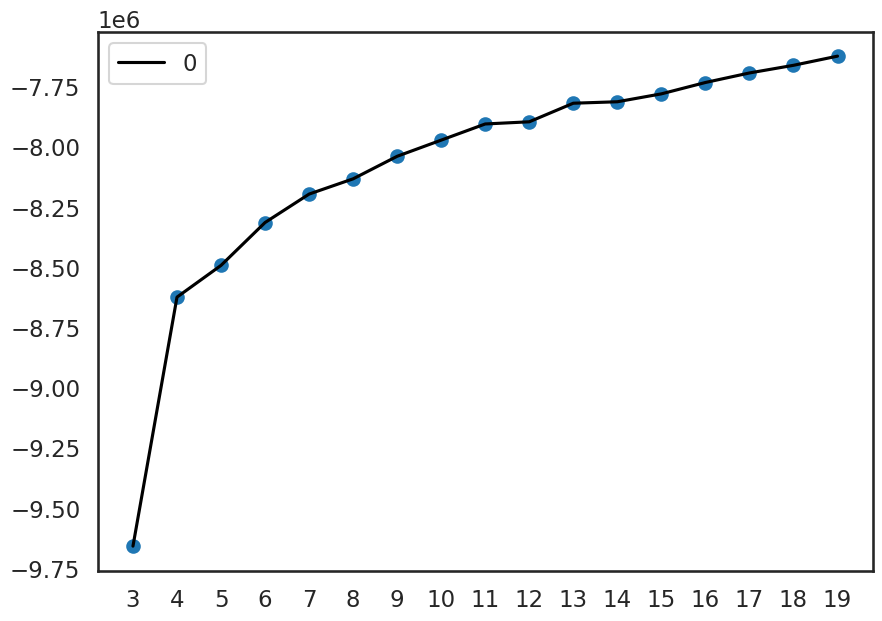

In [3]:
N = np.arange(3,20)
LogLikelihood = np.load('../SocialData/HMMData/LogLikelihood.npy', allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize = (10,7))
for i in range(len(LogLikelihood)):
    loglikelihood = LogLikelihood[i]
    axs.scatter(N, loglikelihood)
    axs.plot(N, loglikelihood, color = 'black', label = i)
axs.set_xticks(N)
axs.legend()
plt.show()

In [6]:
from dotmap import DotMap
def find_obj(dotmap, obj):
    """Returns a list of objects of type `obj` found in a DotMap."""
    objs = []
    for value in dotmap.values():
        if isinstance(value, obj):
            objs.append(value)
        elif isinstance(value, DotMap):
            objs.extend(find_obj(value, obj))
    return objs

root = [Path("/ceph/aeon/aeon/data/raw/AEON3/social0.2")]

mouse_pos = pd.read_parquet('../SocialData/HMMData/' + 'Pre' + "_" + 'BAA-1104045' + '.parquet', engine='pyarrow')
start_time, end_time = mouse_pos.index[0], mouse_pos.index[-1]
readers = find_obj(social02, reader.Reader)

for r in readers:
    if r.pattern != 'Patch1_32_*': continue
    data = aeon.load(root, r, start=start_time, end=end_time)
    print(r.pattern)
    display(data.head())

Patch1_32_*


,event
time,
2024-01-31 14:33:12.672063828,PelletDetected
2024-01-31 14:33:36.218304157,PelletDetected
2024-01-31 14:34:07.317376137,PelletDetected
2024-01-31 14:34:14.670720100,PelletDetected
2024-01-31 14:34:35.328512192,PelletDetected
...,...
2024-02-03 13:00:12.245024204,PelletDetected
2024-02-03 13:00:12.257376194,PelletDetected
2024-02-03 13:00:50.377024174,PelletDetected


In [70]:
readers = find_obj(social02, reader.Reader)

for r in readers:
    if r.pattern != 'Patch3_90_*': continue
    print()

Patch3_90_*


In [11]:
print(social02.Patch1.BeamBreak.pattern)

Patch1_32_*


In [54]:
readers = find_obj(exp02, reader.Reader)
for r in readers:
    print(r.pattern)

Metadata
ExperimentalMetadata_EnvironmentState_*
ExperimentalMetadata_SubjectState_*
ExperimentalMetadata_MessageLog_*
CameraTop_*
CameraTop_200_*
CameraTop_201_*
CameraEast_*
CameraNest_*
CameraNorth_*
CameraPatch1_*
CameraPatch2_*
CameraSouth_*
CameraWest_*
Nest_200_*
Nest_202_*
Nest_204_*
Patch1_State_*
Patch1_90_*
Patch1_32_*
Patch1_35_*
Patch2_State_*
Patch2_90_*
Patch2_32_*
Patch2_35_*


In [12]:
exp02.Patch2.BeamBreak.pattern

'Patch2_32_*'

In [99]:
print(exp02.Patch2.Encoder.pattern)

Patch2_90_*


In [92]:
print(social02.Patch3.DeliverPellet.pattern)

Patch3_35_*


In [43]:
mouse_pos = pd.read_parquet('../SocialData/HMMData/' + 'Pre' + "_" + 'BAA-1104047' + '.parquet', engine='pyarrow')

start = pd.Timestamp('2024-02-07 02:00:00.00')
end_ = mouse_pos.index[-1]

while start < end_:
    print(start)
    end = start + pd.Timedelta('3599S')
    encoder = aeon.load(root, social02.Patch2.Encoder, start=start, end=end)
    start = end

2024-02-07 02:00:00
2024-02-07 02:59:59
2024-02-07 03:59:58
2024-02-07 04:59:57
2024-02-07 05:59:56
2024-02-07 06:59:55
2024-02-07 07:59:54
2024-02-07 08:59:53
2024-02-07 09:59:52
2024-02-07 10:59:51
2024-02-07 11:59:50
2024-02-07 12:59:49
2024-02-07 13:59:48
2024-02-07 14:59:47
2024-02-07 15:59:46
2024-02-07 16:59:45
2024-02-07 17:59:44
2024-02-07 18:59:43
2024-02-07 19:59:42
2024-02-07 20:59:41
2024-02-07 21:59:40
2024-02-07 22:59:39
2024-02-07 23:59:38
2024-02-08 00:59:37
2024-02-08 01:59:36
2024-02-08 02:59:35
2024-02-08 03:59:34
2024-02-08 04:59:33
2024-02-08 05:59:32
2024-02-08 06:59:31
2024-02-08 07:59:30
2024-02-08 08:59:29
2024-02-08 09:59:28
2024-02-08 10:59:27
2024-02-08 11:59:26
2024-02-08 12:59:25
2024-02-08 13:59:24


In [114]:
from datetime import datetime, timedelta
mouse_pos = pd.read_parquet('../SocialData/HMMData/' + 'Post' + "_" + 'BAA-1104047' + '.parquet', engine='pyarrow')


start = mouse_pos.index[0]
end = mouse_pos.index[-1]

while start < end:
    if start.minute != 0:
        end_ = pd.Timestamp(year = start.year, month = start.month, day = start.day, hour = start.hour+1, minute=0, second=0) - pd.Timedelta('2S')
    else:
        end_ = start + pd.Timedelta('1H') - pd.Timedelta('2S')
    start_ = start + pd.Timedelta('1S')
    print(start_, end_)
    encoder = aeon.load(root, social02.Patch3.Encoder, start=start_, end=end_)
    start = end_ + pd.Timedelta('2S')

'''while start < end_:
    print(start)
    end = start + pd.Timedelta('1H')
    encoder = aeon.load(root, social02.Patch2.Encoder, start=start, end=end)
    start = end'''

2024-02-28 13:56:21.480000 2024-02-28 13:59:58
2024-02-28 14:00:01 2024-02-28 14:59:58
2024-02-28 15:00:01 2024-02-28 15:59:58
2024-02-28 16:00:01 2024-02-28 16:59:58
2024-02-28 17:00:01 2024-02-28 17:59:58
2024-02-28 18:00:01 2024-02-28 18:59:58
2024-02-28 19:00:01 2024-02-28 19:59:58
2024-02-28 20:00:01 2024-02-28 20:59:58
2024-02-28 21:00:01 2024-02-28 21:59:58
2024-02-28 22:00:01 2024-02-28 22:59:58
2024-02-28 23:00:01 2024-02-28 23:59:58
2024-02-29 00:00:01 2024-02-29 00:59:58
2024-02-29 01:00:01 2024-02-29 01:59:58
2024-02-29 02:00:01 2024-02-29 02:59:58
2024-02-29 03:00:01 2024-02-29 03:59:58
2024-02-29 04:00:01 2024-02-29 04:59:58
2024-02-29 05:00:01 2024-02-29 05:59:58
2024-02-29 06:00:01 2024-02-29 06:59:58
2024-02-29 07:00:01 2024-02-29 07:59:58
2024-02-29 08:00:01 2024-02-29 08:59:58
2024-02-29 09:00:01 2024-02-29 09:59:58
2024-02-29 10:00:01 2024-02-29 10:59:58
2024-02-29 11:00:01 2024-02-29 11:59:58
2024-02-29 12:00:01 2024-02-29 12:59:58
2024-02-29 13:00:01 2024-02-29 13

"while start < end_:\n    print(start)\n    end = start + pd.Timedelta('1H')\n    encoder = aeon.load(root, social02.Patch2.Encoder, start=start, end=end)\n    start = end"

In [105]:
start = pd.Timestamp('2024-03-01 16:00:01')
end_ = pd.Timestamp('2024-03-01 16:59:58.0')
encoder = aeon.load(root, social02.Patch3.Encoder, start=start, end=end_)

In [2]:
LABELS = [
    ['Pre','BAA-1104045'],
    ['Pre','BAA-1104047'],
    ['Post','BAA-1104045'],
    ['Post','BAA-1104047']
]

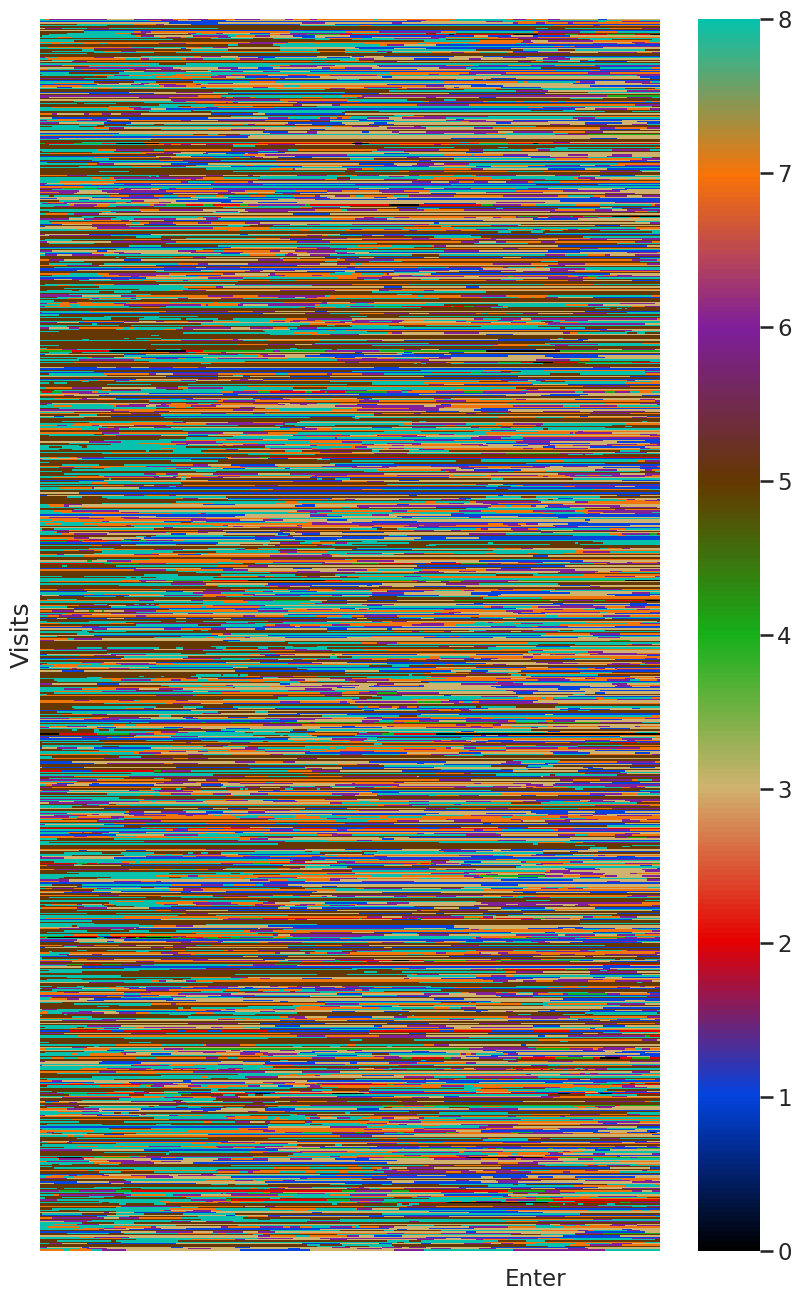

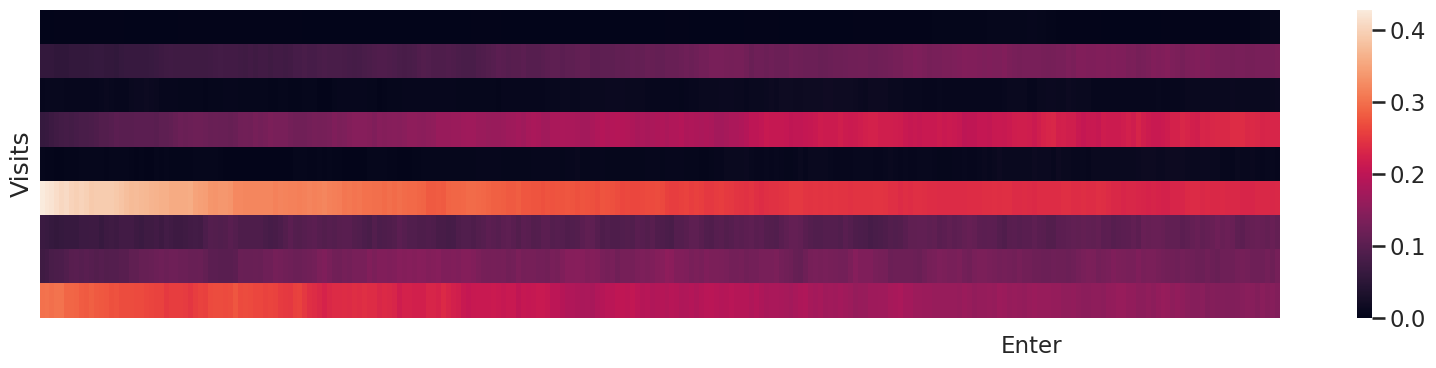

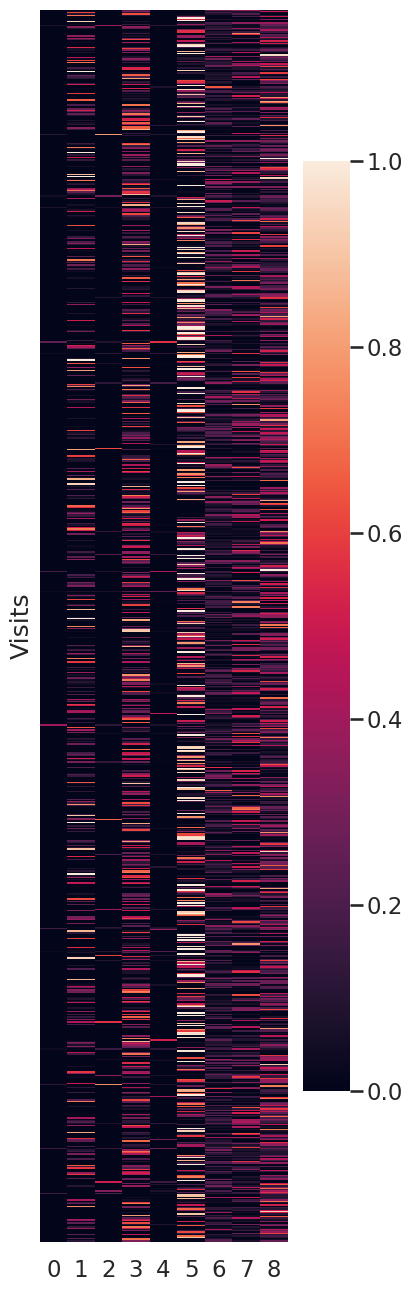

In [10]:
from collections import Counter
n=9
STATE, DURATION = [],[]
for label in LABELS:
    type, mouse = label[0], label[1]
    mouse_pos = pd.read_parquet('../SocialData/HMMData/' + type + "_" + mouse + '.parquet', engine='pyarrow')
    states = np.load('../SocialData/HMMStates/' + type + "_" + mouse + "_States.npy", allow_pickle = True)
    mouse_pos['state'] = pd.Series(states, index = mouse_pos.index)
    
    Visits = pd.read_parquet('../SocialData/VisitData/'  + type + "_" + mouse +'_Visit.parquet', engine='pyarrow')
    Visits = Visits.dropna(subset=['speed'])
    Visits['distance'] = abs(Visits['distance'])
    Visits = Visits[Visits['distance'] >= 0.1]
    
    for i in range(len(Visits)):
        trigger = Visits.iloc[i]['start']
        
        latest_valid_index = mouse_pos.loc[trigger - pd.Timedelta('21S'):trigger, 'state'].index
        latest_valid_state = mouse_pos.loc[latest_valid_index, ['state']].values.reshape(-1)
        if len(latest_valid_state) >= 200: latest_valid_state  = latest_valid_state[-200:]
        
        next_valid_index = mouse_pos.loc[trigger:trigger + pd.Timedelta('6S'), 'state'].index
        next_valid_state = mouse_pos.loc[next_valid_index, ['state']].values.reshape(-1)
        if len(next_valid_state) >= 50: next_valid_state  = next_valid_state[:50]
        state = np.concatenate((latest_valid_state, next_valid_state))
        if len(state) == 0: continue
        
        STATE.append(state)
        DURATION.append(Visits.iloc[i]['duration'])

index = np.argsort(DURATION)
STATES = np.array(STATES)[index]

N = n
colors = sns.xkcd_palette(color_names[0:N])
cmap = gradient_cmap(colors)

fig, axs = plt.subplots(1, 1, figsize=(10, 16))
sns.heatmap(STATES,cmap=cmap, ax=axs, vmin=0, vmax = N-1, cbar = True)
axs.set_aspect('auto')

axs.set_xticks([200])
axs.set_xticklabels(['Enter'], rotation = 0)

axs.set_ylabel("Visits")
axs.set_yticks([])

plt.savefig('../Images/Social_HMM/EnterVisit.png')
plt.show()


AVE_STATES = []
AVE_STATES_D = []
for k in np.arange(n):
    index = STATES == k
    states = index*1
    AVE_STATES.append(np.mean(states, axis = 0))
    AVE_STATES_D.append(np.mean(states, axis = 1))

fig, axs = plt.subplots(1, 1, figsize=(20, 4))
sns.heatmap(AVE_STATES,ax=axs)
axs.set_aspect('auto')

axs.set_xticks([200])
axs.set_xticklabels(['Enter'], rotation = 0)

axs.set_ylabel("Visits")
axs.set_yticks([])

plt.savefig('../Images/Social_HMM/EnterVisit_' + 'EachState' + '.png')
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(4, 16))
sns.heatmap(np.array(AVE_STATES_D).T,ax=axs)
axs.set_aspect('auto')

axs.set_ylabel("Visits")
axs.set_yticks([])

plt.savefig('../Images/Social_HMM/EnterVisit_' + 'EachState_D' + '.png')
plt.show()

In [8]:
states_before_forage

8